In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Problem 1

In [2]:
link = "https://raw.githubusercontent.com/sievers/phys512-2020/master/problem_sets/dish_zenith.txt"
x,y,z = np.loadtxt(link, unpack = True)

### a)
We fit the coordinates on the dish with:
\begin{equation}
z - z_0 = a((x-x_0)^2 + (y-y_0)^2)
\end{equation}

Introducing new parameters to linearize the model:


$ z = a(x^2 + y^2) + (-2ax_0)x + (-2ay_0)y + (a{x_0}^2 + a{y_0}^2 + z_0) = a(x^2 + y^2) + bx +cy + d$


The old parameters will then be given by:

\begin{equation}
a = a 
\end{equation}
\begin{equation}
x_0 = - b/2a 
\end{equation}
\begin{equation}
y_0 = -c/2a 
\end{equation}
\begin{equation}
z_0 = d - ax_0^2 - ay_0^2
\end{equation}

### b)

Best-fit parameters [0.0001667, -1.36048862, 58.22147608, -1512.87721004]


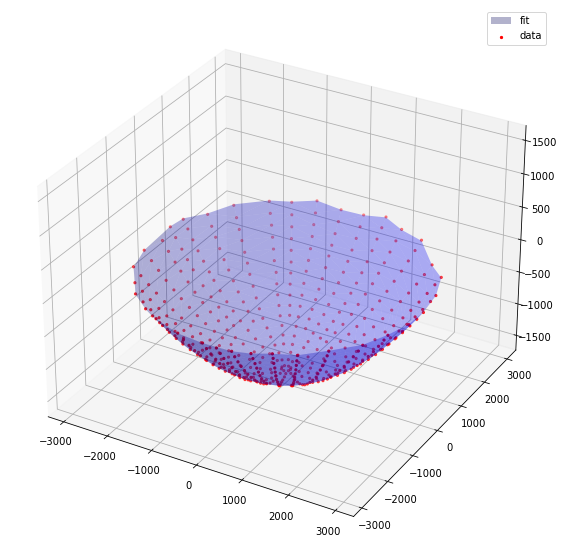

In [3]:
A = np.zeros((len(x), 4))
A[:,0] = x**2 + y**2 
A[:,1] = x
A[:,2] = y
A[:,3] = 1.

sig = 1    # for now let's use 1
N = sig**2*np.eye(len(x))
Ninv = np.linalg.inv(N)
lhs = A.T@(Ninv@A)
rhs = A.T@(Ninv@z)
lhs_inv = np.linalg.inv(lhs) #the condition number allows to use the standard approach
m = lhs_inv@rhs
z_pred = A@m

pars = np.zeros(4)
pars[0] = m[0]; a = pars[0]  # a
pars[1] = -m[1]/2/a         #x_0
pars[2] = -m[2]/2/a         #y_0
pars[3] = m[3] - a*pars[1]**2 - a*pars[2]**2   #z_0
print('Best-fit parameters',[float('%.8f'% p) for p in pars])

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(x, y, z_pred, color = 'b', label = 'fit', alpha = 0.3)
surf._facecolors2d=surf._facecolors3d  # this is fixing some bug with 3D plot
surf._edgecolors2d=surf._edgecolors3d  # this is fixing some bug with 3D plot
ax.scatter(x, y, z, marker = '.', color = 'r', label = 'data')
ax.scatter(0, 0, 1500, marker = '.', alpha = 0) # adding an invisible point to change the aspect ratio og the 3D plot
ax.legend()
plt.show()

### c)

In [4]:
z_std = np.std(z-z_pred)
print('Noise in the data:',float('%.3f'% z_std),'mm')   # estimate noise as standart deviation of z from the fit
# now redo the calculations for N and A to get par errors, pars themselves won't change as we use equal weignts (same sigma) for all data points
N = z_std**2*np.eye(len(x))
Ninv = np.linalg.inv(N) 
lhs = A.T@(Ninv@A)    
lhs_inv = np.linalg.inv(lhs)
m_errors = np.sqrt(np.diag(lhs_inv))
print('Uncertainty in a:',float('%.3e'% m_errors[0]), 'mm^-1')

Noise in the data: 3.768 mm
Uncertainty in a: 6.452e-08 mm^-1




We have $a = \frac{1}{4f}$, so focal length $f = \frac{1}{4a}$, error for the focal length $\delta f = |\frac{\partial f}{\partial a}| \delta a = \frac{1}{4a^2} \delta a $


In [5]:
f = 1/4/a
f_error = 1/4/a/a*m_errors[0]
print('f =',float('%.3f'% f),'+-',float('%.3f'% f_error),'mm')

f = 1499.66 +- 0.58 mm


#### BONUS:

Now fit the dish with $z = z_0 + ax'^2 + by'^2$, where $x'$ and $y'$ are related to $x, y$ by a rotation.  


If we use the relation between the coordinate systems, add arbitrary offsets and expand the expression , we get:

\begin{equation}
z = Ax^2 + By^2 +2Cxy +(-2Ax_0 - 2Cy_0)x + (-2By_0 - 2Cx_0)y +(Ax_0^2 + By_0^2 + 2Cx_0y_0 + z_0),
\end{equation}
where 
\begin{equation}
A = a cos^2\theta + b sin^2\theta
\end{equation}
\begin{equation}
B = a sin^2\theta + b cos^2\theta
\end{equation}
\begin{equation}
C = (a-b) sin\theta cos\theta
\end{equation}

Knowing A, B, and C, we solve the system of equations for $a, b$ (and $\theta$). We obtain:
\begin{equation}
tan2\theta = \frac{2C}{A-B} 
\end{equation}
\begin{equation}
2a = A + B + \frac{A-B}{cos2\theta} 
\end{equation}
\begin{equation}
2b = A + B - \frac{A-B}{cos2\theta} 
\end{equation}


In [6]:
# the model now includes columns for x^2, y^2, xy, x, y, and const
A = np.zeros((len(x), 6)) 
A[:,0] = x**2
A[:,1] = y**2 
A[:,2] = x*y
A[:,3] = x
A[:,4] = y
A[:,5] = 1.

sig = z_std    
N = sig**2*np.eye(len(x))
Ninv = np.linalg.inv(N)
lhs = A.T@(Ninv@A)
rhs = A.T@(Ninv@z)
lhs_inv = np.linalg.inv(lhs)
m = lhs_inv@rhs
z_pred = A@m

print('z std: '+'%.3f'% np.std(z-z_pred)+' mm')

A = m[0]
B = m[1]
C = m[2]/2.

tan2t = 2.*C/(A-B)
cos2t = 1./np.sqrt(1. + tan2t**2) #it is actually +-1/sqrt(...), but the sign just switches the two principal axes and f1/f2
a = 0.5*(A + B + (A - B)/cos2t)
b = 0.5*(A + B - (A - B)/cos2t)

f1 = 1/4/a
f2 = 1/4/b

print('f1: '+ '%.3f'% f1 +' mm')
print('f2: '+'%.3f'% f2 + ' mm')

z std: 1.679 mm
f1: 1508.488 mm
f2: 1490.219 mm


Firstly, the corrected fit does better and we get lower z errors; \
secondly, we can see that the dish is not quite round!